# 0 Setup

In [1]:
# setup for google colab
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = '/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis/'
os.chdir(project_path)
!ls

Mounted at /content/drive


In [1]:
# setup for ipython
import os
project_path = '/Users/mariusprivat/Google Drive/DataScience/supercoop/supercoapp-data-analysis'
os.chdir(project_path)
!ls

# 1 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib v3.2.2
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()

import src
import warnings
warnings.filterwarnings('ignore') # delete normal warnings to make code more clean

In [3]:
# lifetimes installation
import sys
!{sys.executable} -m pip install lifetimes
# lifetimes loading
from lifetimes.plotting import * # lifetimes visualization
from lifetimes.utils import * # transform

from lifetimes import BetaGeoFitter # BG/NBD model

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix

# 1 Load Data

In [4]:
# set relative folder path
rel_folder_path = '/data/processed/'
# load data
df_orders, df_members, df_products = src.load_data(project_path + rel_folder_path)

['20210417_scoop_orders.csv', '.DS_Store', '20210518_scoop_rfm_table.csv', '20210417_scoop_products.csv', '20210417_scoop_members.csv']
reminder: data from scoop company account (#46) is included


In [5]:
df_members[df_members.name == 'Supercoop'].head()

,index,member_ID,order_ID,name,collected?,order_requests,deposits,delivery_date,order_request_value
53,53,46,3,Supercoop,True,"{'24': {'filled': '0', 'ordered': '1.0'}, '205...",NaN,2020-02-20,0.97
74,74,46,4,Supercoop,True,"{'754': {'filled': '0', 'ordered': '26.0'}}",NaN,2020-03-06,0.00
98,98,46,5,Supercoop,True,"{'350': {'filled': '0', 'ordered': '3.0'}, '36...",NaN,2020-03-06,0.00
127,127,46,7,Supercoop,True,"{'395': {'filled': '', 'ordered': '0.7'}, '847...",NaN,2020-03-13,4.83
152,152,46,8,Supercoop,True,"{'337': {'filled': '1', 'ordered': '3.0'}, '34...",NaN,2020-03-13,5.76


In [7]:
df_members

,index,member_ID,order_ID,name,collected?,order_requests,deposits,delivery_date,order_request_value
0,0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,2019-12-13,89.49
1,1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,2019-12-13,16.22
2,2,3,1,XXX,True,"{'3': {'filled': '0.0', 'ordered': '2.0'}, '7'...",NaN,2019-12-13,20.28
3,3,4,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '4...",NaN,2019-12-13,11.96
4,4,7,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '1...",NaN,2019-12-13,17.32
...,...,...,...,...,...,...,...,...,...
3814,3814,58,320,XXX,True,{'new_product_7': {'filled': '2'}},NaN,2021-03-19,1.20
3815,3815,74,320,XXX,True,{'new_product_18': {'filled': '1'}},NaN,2021-03-19,1.98
3816,3816,77,320,XXX,True,{'new_product_4': {'filled': '1'}},NaN,2021-03-19,5.42
3817,3817,78,320,XXX,True,{'new_product_7': {'filled': '2'}},NaN,2021-03-19,1.20


# 2 Data Cleaning

In [8]:
cols_of_interest = ['member_ID', 'delivery_date', 'order_request_value'] # select three variables that we are most caring
df = df_members[cols_of_interest]

print(df.head())
print(df['member_ID'].nunique()) # how many unique customerID

   member_ID delivery_date  order_request_value
0          1    2019-12-13                89.49
1          2    2019-12-13                16.22
2          3    2019-12-13                20.28
3          4    2019-12-13                11.96
4          7    2019-12-13                17.32
64


In [9]:
# removing supercoop company account
df = df.loc[df.member_ID != 46]

# remove outlier in monetary_value who just made one very big order
print(df[df.member_ID == 31])

df_clean = df.loc[df.member_ID != 31]

    member_ID delivery_date  order_request_value
12         31    2019-12-13               186.85


In [9]:
df_clean.describe(include='all')

,member_ID,delivery_date,order_request_value
count,3695.000000,3695,3695.000000
unique,NaN,89,NaN
top,NaN,2020-12-04 00:00:00,NaN
freq,NaN,92,NaN
first,NaN,2019-12-13 00:00:00,NaN
last,NaN,2021-03-19 00:00:00,NaN
mean,31.869283,NaN,16.464484
std,21.879932,NaN,18.849686
min,1.000000,NaN,-5.900000
25%,11.000000,NaN,4.250000


# 3 Create RFM DataFrame

## 3.1 Dataframe with lifetimes module



In [10]:
# tranform data into RFM format with lifetimes
# transfer into dataframe that has "member_ID" as primary key and get info for frequency, recency and monetary value
data = summary_data_from_transaction_data(df_clean, 'member_ID', 'delivery_date', 
                                          monetary_value_col='order_request_value',
                                          freq='W', # timeinterval of T
                                          observation_period_end='2020-11-12',
                                          include_first_transaction=True)

data.tail(10)

,frequency,recency,T,monetary_value
member_ID,,,,
52,11.0,10.0,23.0,46.553636
54,14.0,13.0,17.0,39.789286
55,12.0,13.0,13.0,20.560833
56,7.0,7.0,13.0,18.902857
57,5.0,7.0,7.0,14.760000
58,3.0,2.0,2.0,25.220000
60,4.0,4.0,4.0,46.990000
61,2.0,2.0,2.0,25.505000
62,3.0,2.0,2.0,23.293333


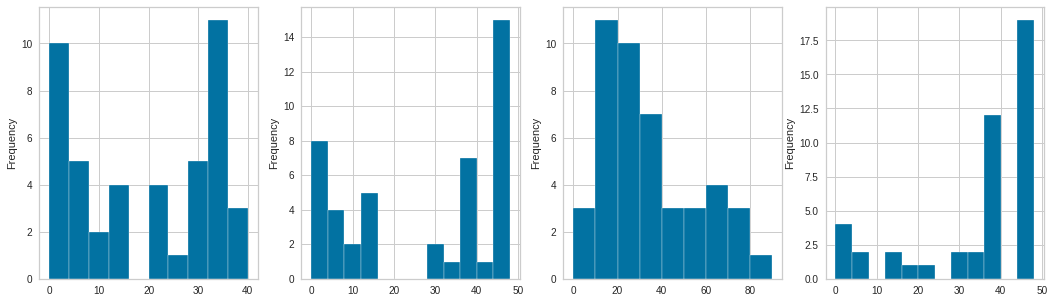

In [ ]:
fig, axs = plt.subplots(1, 4,
                        figsize=(18, 5))

# frequency distribution
data['frequency'].plot(kind='hist', 
                       bins=range(0, int(max(data['frequency']))+4, 4),
                       xlabel='number of repeted orders',
                       ylabel='unique member count',
                       #use_index=False,
                       ax=axs[0]
                       )

# recency distribution

# recency represents the duration between a customer’s first purchase and their latest purchase. 
# (Thus if they have made only 1 purchase, the recency is 0.)

data['recency'].plot(kind='hist', 
                     bins=range(0, int(max(data['recency'])+4), 4),
                     xlabel='recency in weeks',
                     ylabel='unique member count',
                     #use_index=False
                     ax=axs[1]
                     )

# monetary value
data['monetary_value'].plot(kind='hist', 
                     bins=range(0, int(max(data['monetary_value'])+10), 10),
                     xlabel='monetary_value per week',
                     ylabel='unique member count',
                     #use_index=False
                     ax=axs[2]
                     )


# time (T) distribution

# T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). 
# This is equal to the duration between a customer’s first purchase and the end of the period under study.

# recency zeigt wie lange die members bei scoop bleiben
data['T'].plot(kind='hist', 
               bins=range(0, int(max(data['T'])+4), 4),
               xlabel='T in weeks',
               ylabel='unique member count',
               #use_index=False,
               ax=axs[3])

In [ ]:
print(data.describe())
print(sum(data['frequency'] == 0) / float(len(data)))

NameError: name 'data' is not defined

### addapting lifetime calculation

Definitions of RFM i am using:

**Recency (R)** – refers to the interval between the time when the latest purchase happens and the present (time since last order)

-> e.g. a recency of zero means that the member participated in an order the week of the end_of_period

**Frequency (F)** – number of intervals where a customer has made an , with two calculation options:

(1) frequency: total number of time periods the member has been activ in

(2) avg. frequency: avg. activity a members lifetime (last_seen - first_seen), 

-> e.g. counting the weeks a member participated in an at least on order and divid it by the total timeperiods of the member from first til last seen

**Monetary (M)** – refers to the cumulative total of money spent by a customer divided by the Frequency. 
* monetary value per timeperiod

In [ ]:
# preparing RFM Dataframe

# copy of data
rfm_table = data.copy()

# renaming lifetimes recency column
rfm_table.rename(columns={'recency': 'lifespan'}, inplace=True)

# calculating time since member ordered last
rfm_table['recency'] = rfm_table['T'] - rfm_table.lifespan

# calculating lifetime frequency (+1 to add first week)
rfm_table['freq_avg'] = rfm_table.frequency / (rfm_table.lifespan + 1)

# counting all orders
rfm_table['order_count'] = df_clean.groupby('member_ID').delivery_date.count()

# reordering column in df
new_col_order = ['recency', 'frequency', 'monetary_value', 
                 'freq_avg', 'order_count', 'lifespan',	'T']
rfm_table = rfm_table[new_col_order]

rfm_table.tail(5)

,recency,frequency,monetary_value,freq_avg,order_count,lifespan,T
member_ID,,,,,,,
58,0.0,3.0,19.383333,1.000000,9,2.0,2.0
60,0.0,4.0,35.012500,0.800000,9,4.0,4.0
61,0.0,2.0,19.295000,0.666667,4,2.0,2.0
62,0.0,3.0,19.640000,1.000000,5,2.0,2.0
63,0.0,3.0,25.953333,1.000000,8,2.0,2.0


In [ ]:
# finding max days a member had between two orders

# get unique delivery dates
df_uniq_delivery = df_clean.groupby('member_ID').delivery_date.unique().reset_index()

# finding max days a member had between two orders
for i, li in enumerate(df_uniq_delivery.delivery_date):
  # sort input
  li = pd.Series(li).sort_values().reset_index(drop=True)
  max_vacancy = li.diff().max()

  if pd.isnull(max_vacancy):
    df_uniq_delivery.loc[i, 'max_vacancy'] = np.timedelta64(0, 'D') 
  else:
    df_uniq_delivery.loc[i, 'max_vacancy'] = max_vacancy

# add result to rfm table in weeks, using set_index to match rows
# TODO .astype('timedelta64[W]') output is float not timedelta,
rfm_table['max_vacancy'] = df_uniq_delivery.set_index('member_ID').max_vacancy.astype('timedelta64[W]')

In [196]:
# plotting histograms
fig, axs = plt.subplots(1, 3,
                        figsize=(20, 5),
                        #sharex=True
                        )

# bin ranges
bins_recency = range(0, int(max(rfm_table['recency'])+5), 5)
bins_frequency = np.linspace(0, max(rfm_table['frequency'])+5, 11)
bins_monetary = range(0, int(max(rfm_table['monetary_value']))+5, 10)


# recency 
rfm_table.recency.plot.hist(bins=bins_recency,
                             xlabel='recency in weeks',
                             ylabel='number of members',
                             title='Recency',
                             ax=axs[0],
                             #cmap=cmap,
                             )
axs[0].set_xlabel('recency in weeks')
axs[0].set_ylabel('number of members')

# frequency - activ on weekly basis
rfm_table.frequency.plot.hist(bins=bins_frequency,
                             title='Frequency - Activity count in Weeks',
                             ax=axs[1],
                             #cmap=cmap,
                             )
axs[1].set_xlabel('frequency of weekly member activity')
axs[1].set_ylabel('number of members')


# monetary value
rfm_table.monetary_value.plot.hist(bins=bins_monetary,
                                   title='Monetary Value',
                                   ax=axs[2], 
                                   #cmap=cmap,
                                   )
axs[2].set_xlabel('avg. order value per week in EUR')
axs[2].set_ylabel('number of members')

NameError: name 'rfm_table' is not defined

In [ ]:
# remove outlier in monetary value who just made one big order
rfm_table = rfm_table.loc[rfm_table.monetary_value < 150]
rfm_table.head(2)

,recency,frequency,monetary_value,freq_avg,order_count,lifespan,T,max_vacancy
member_ID,,,,,,,,
1,0.0,37.0,88.508649,0.755102,106,48.0,48.0,69 days
2,2.0,33.0,24.096364,0.702128,84,46.0,48.0,69 days


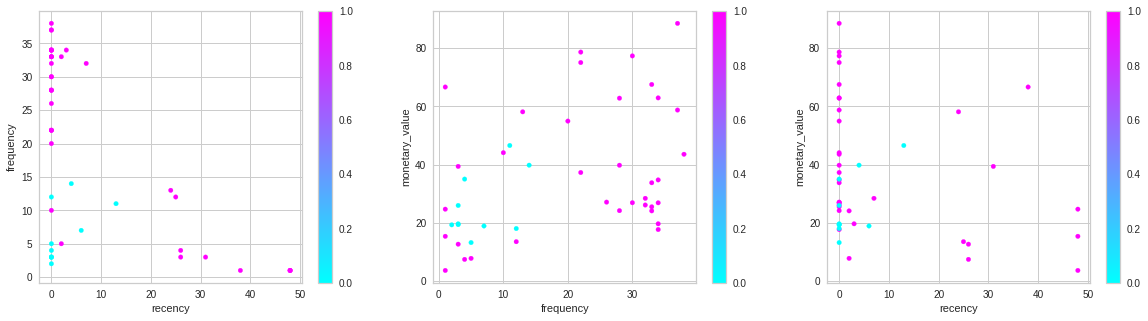

In [ ]:
# Scatterplots

# set hue
hue = rfm_table['T'] >= 24
# set colors
cmap = 'cool'

fig, axs = plt.subplots(1, 3,
                        figsize=(20, 5),
                        #sharex=True
                        )

# recency vs frequency_per_time
rfm_table.plot(kind='scatter',
                x='recency', 
                y='frequency',
                ax=axs[0],
                c=hue,
                cmap=cmap
                )

# frequency vs monetary value
rfm_table.plot(kind='scatter',
                x='frequency', 
                y='monetary_value',
                ax=axs[1],
                c=hue,
                cmap=cmap)


# recency vs monetary value
rfm_table.plot(kind='scatter',
                x='recency', 
                y='monetary_value',
                ax=axs[2],
                c=hue,
                cmap=cmap)

## 3.2 RFM-Dataframe manual

In [10]:
def make_table(df_members, freq):
    '''
    a function to create an rfm_table from a transactions dataframe.

    takes in the df_members dataframe, filters out the supercoop company account and
    calculates recency (time period since last delivery), frequency (count of active periods - default period is weeks),
    monetary_value (avg. monetary_value per period)

    default period is set to weeks
    example:
        rfm_table = src.create_table(df_members, freq='W')
    '''
    # select columns of interest
    cols_of_interest = ['member_ID', 'delivery_date', 'order_request_value']
    df = df_members[cols_of_interest].copy()
    # removing supercoop company account
    df = df.loc[df.member_ID != 46]

    # create rfm table
    period_end = df.delivery_date.max()

    # set delivery_date as index to convert into PeriodIndex of freq
    # then cast back to DatetimeIndex of timestamps, at beginning of period.
    rfm_table = df.set_index('delivery_date').to_period(
        freq).to_timestamp().reset_index()

    # sum all orders based on member_id and time (week)
    rfm_table = rfm_table.groupby(['delivery_date', 'member_ID'],
                                  sort=False, as_index=False).sum()

    # get the most recent delivery_date, the frequencycount of deliverys and the mean order value
    rfm_table = rfm_table.groupby('member_ID').agg({'delivery_date': 'max', 'member_ID': 'count',
                                                    'order_request_value': 'mean'})
    # rename all columns
    rfm_table.rename(columns={'delivery_date': 'recency', 'member_ID': 'frequency',
                              'order_request_value': 'monetary_value'}, inplace=True)

    # calculating recency (with floor devision)
    freq_timedeltas = {'W': np.timedelta64(1, 'W'), 'M': np.timedelta64(1, 'M'),
                       'Q': np.timedelta64(3, 'M')}
    rfm_table['recency'] = (period_end - rfm_table['recency']) // freq_timedeltas[freq]

    # set dataframe name for csv_export
    rfm_table.df_name = 'rfm_table'
    rfm_table._metadata += ['df_name']

    return rfm_table

# 4 RFM Segmentation





This segment includes different ways of RFM Segmentation. Two of them naive and two with sklearn's Kmeans


(1) [RFM Segmentation using quantiles (modes)](https://www.businessanalytics.co.nz/post/2020-03-25-rfm-cohort-and-survival-analyses/)

* RFM Segmentation, 
* Cohort and Survival Analyses
* includes nice plots

(2) [Naive RFM Segmentation Example w/ Python](https://aainabajaj39.medium.com/rfm-analysis-for-successful-customer-segmentation-using-python-6291decceb4b)
* using mode-quantiles for segmentation

**KMeans Clustering example:**

(3) [customers-segmentation-with-rfm-analysis-and-k-means-clustering](https://medium.com/swlh/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-93aa4c79f7a7)

* with Python code
* KMeans Clustering
* preprocessing includes Normalization 

(4) https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232

* with Python code
* KMeans Clustering using all features (RFM)
  * min-max Normalization
  * identify optimal k clusters
  * silhouette plot of clusters

## 4.1. Naive Approach

In [11]:
def add_score(rfm_table, freq):
    '''a function calculating the rfm_score
    using manually scaled bin range for recency (where low values score highest)
    and quartile bin ranges for frequency and monetary value.

    example:
        rfm_table_w_score = src.score(rfm_table, freq='W')
    '''
    # recency score
    # scale recency bin range beased on freq
    r_range = [0, 0.25, 0.5, 1, np.inf]
    freqs = {'W': 52, 'M': 12, 'Q': 4}
    r_range = [x * freqs[freq] for x in r_range]

    # use pd.cut create and label bins
    r_labels, r_bins = pd.cut(rfm_table.recency, bins=r_range, labels=[4, 3, 2, 1],
                              retbins=True, include_lowest=True)
    rfm_table['r_score'] = r_labels

    # frequency
    f_labels, f_bins = pd.qcut(rfm_table.frequency, 4,
                               retbins=True, labels=range(1, 5))
    rfm_table['f_score'] = f_labels

    # monetary value
    m_labels, m_bins = pd.qcut(rfm_table.monetary_value, 4,
                               retbins=True, labels=range(1, 5))
    rfm_table['m_score'] = m_labels

    # combined rfm score
    rfm_table['rfm_score'] = (rfm_table.r_score.astype(str) + rfm_table.f_score.astype(str)
                              + rfm_table.m_score.astype(str))

    # gather bin info to add in plots
    bin_info = {'r': r_bins, 'f': f_bins, 'm': m_bins}

    return rfm_table, bin_info

In [12]:
def main(df_members, freq='W', export=True):
    '''
    example:
        rfm_table = src.rfm.main(df_members)
    '''
    # TODO docstring

    # check if freq input is valid
    if freq not in ['W', 'M']:
        print("Your input is not valid! Choose either ['W', 'M'] as freq.")

    # create rfm table
    rfm_table = make_table(df_members, freq)
    # add rfm score
    rfm_table, bin_info = add_score(rfm_table, freq)

    # export rfm table as csv to processed
    if export is True:
        script_dir = os.path.dirname(os.path.abspath(__file__))
        RELATIV_EXPORT_PATH = '../../data/processed/'
        abs_export_path = os.path.join(script_dir, RELATIV_EXPORT_PATH)

        export_as_csv([rfm_table], abs_export_path)
        print('export rfm_table done')

    return rfm_table, bin_info

In [13]:
df

,member_ID,delivery_date,order_request_value
0,1,2019-12-13,89.49
1,2,2019-12-13,16.22
2,3,2019-12-13,20.28
3,4,2019-12-13,11.96
4,7,2019-12-13,17.32
...,...,...,...
3814,58,2021-03-19,1.20
3815,74,2021-03-19,1.98
3816,77,2021-03-19,5.42
3817,78,2021-03-19,1.20


In [14]:
# make table
freq = 'W' # ['W', 'M']
rfm_table_manual, bin_info = main(df_members, freq, export=False)
rfm_table_manual

,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_score
member_ID,,,,,,,
1,0,55,101.340727,4,4,4,444
2,0,51,23.025098,4,4,1,441
3,15,37,58.837838,3,3,4,334
4,66,1,15.360000,1,1,1,111
6,0,48,72.551667,4,4,4,444
...,...,...,...,...,...,...,...
78,0,4,29.282500,4,1,2,412
79,0,7,56.580000,4,2,4,424
81,0,2,24.710000,4,1,2,412


### analysis and plots

In [89]:
# adding segements
# regex replace dictionary
segment_map = {
    r'[4][3-4]': 'loyal members',
    r'[4][1-2]': 'new members',
    r'[3][1-4]': 'at risk',
    r'[1-2][1-2]': 'lost',
}

rfm_table_manual['Segment'] = rfm_table_manual.r_score.astype(str) + rfm_table_manual.f_score.astype(str)
rfm_table_manual['Segment'] = rfm_table_manual['Segment'].replace(segment_map, regex=True)
rfm_table_manual.head()


,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_score,Segment
member_ID,,,,,,,,
1,0,55,101.340727,4,4,4,444,loyal members
2,0,51,23.025098,4,4,1,441,loyal members
3,15,37,58.837838,3,3,4,334,at risk
4,66,1,15.360000,1,1,1,111,lost
6,0,48,72.551667,4,4,4,444,loyal members


In [107]:
# add segemtent names to plot TODO ?
print(segment_map)
heatmap_labels.loc[4:3,4] = 'loyal members'
heatmap_labels.loc[2:1,4] = 'new members'
heatmap_labels.loc[3:1,3] = 'at risk'
heatmap_labels.loc[2,1:2] = 'lost members'
print(heatmap_labels)

# define values in plot
heatmap_count_flatten = heatmap_count.to_numpy().flatten()
heatmap_mv_flatten = heatmap_mv.to_numpy().flatten()

labels = np.asarray(["{0:.0f} Members\n{1:.2f} EUR avg. Spending ".format(count, mv) for count, mv in (zip(heatmap_count_flatten.flatten(), heatmap_mv_flatten.flatten()))]).reshape(4,4)
labels

#heatmap_labels.replace(segment_map)

{'[4][3-4]': 'loyal members', '[4][1-2]': 'new members', '[3][1-4]': 'at risk', '[1-2][1-2]': 'lost'}


r_score,1,2,3,4
f_score,,,,
4,NaN,NaN,NaN,loyal members
3,NaN,NaN,at risk,loyal members
2,lost members,lost members,at risk,new members
1,lost members,lost members,at risk,new members


### Plot (Heatmap (+Labels), Distributions)

In [15]:
rfm_for_analysis = rfm_table_manual.copy()

In [16]:
# create matrix member count 
heatmap_count = rfm_for_analysis.groupby(['f_score', 'r_score']).m_score.count().unstack()
heatmap_count.replace(0, np.nan, inplace=True)
heatmap_count.sort_index(axis=0, ascending=False, inplace=True) # sort index
heatmap_count.sort_index(axis=1, ascending=False, inplace=True) # sort columns
# create matrix avg. monetary value
heatmap_mv = rfm_for_analysis.groupby(['f_score', 'r_score']).monetary_value.mean().unstack()
heatmap_mv.sort_index(axis=0, ascending=False, inplace=True) # sort index
heatmap_mv.sort_index(axis=1, ascending=False, inplace=True) # sort columns

In [124]:
# makeing heatmap labels
# flatten and zip so labels can be used in for loop
heatmap_labels_flatten = zip(heatmap_count.to_numpy().flatten(), heatmap_mv.to_numpy().flatten())
# add text to label values
heatmap_labels = np.asarray(["{0:.0f} Members\n{1:.2f} EUR avg. Spending".format(count, mv) for count, mv in heatmap_labels_flatten])
# reshape labels to fit heatmap
heatmap_labels = heatmap_labels.reshape(4,4)
heatmap_labels

array([['nan Members\nnan EUR avg. Spending',
        'nan Members\nnan EUR avg. Spending',
        'nan Members\nnan EUR avg. Spending',
        '16 Members\n49.28 EUR avg. Spending'],
       ['nan Members\nnan EUR avg. Spending',
        'nan Members\nnan EUR avg. Spending',
        '3 Members\n35.63 EUR avg. Spending',
        '11 Members\n38.36 EUR avg. Spending'],
       ['nan Members\nnan EUR avg. Spending',
        '3 Members\n39.39 EUR avg. Spending',
        '2 Members\n29.35 EUR avg. Spending',
        '12 Members\n33.05 EUR avg. Spending'],
       ['5 Members\n59.43 EUR avg. Spending',
        '3 Members\n19.82 EUR avg. Spending',
        '2 Members\n7.38 EUR avg. Spending',
        '6 Members\n44.97 EUR avg. Spending']], dtype='<U34')

In [75]:
# adding n and T to graph
n = len(rfm_for_analysis.index)
t_min, t_max = pd.Period(df.delivery_date.min(), 'M'), pd.Period(df.delivery_date.max(), 'M')

n, t_min, t_max, str(t_min)

(63, Period('2019-12', 'M'), Period('2021-03', 'M'), '2019-12')

Text(0.0, 1, '$^1$ Recency Score Intervals    4: [0 - 13] > 3: (13 - 26] > 2: (26 - 52] > 1: (52 - inf)')

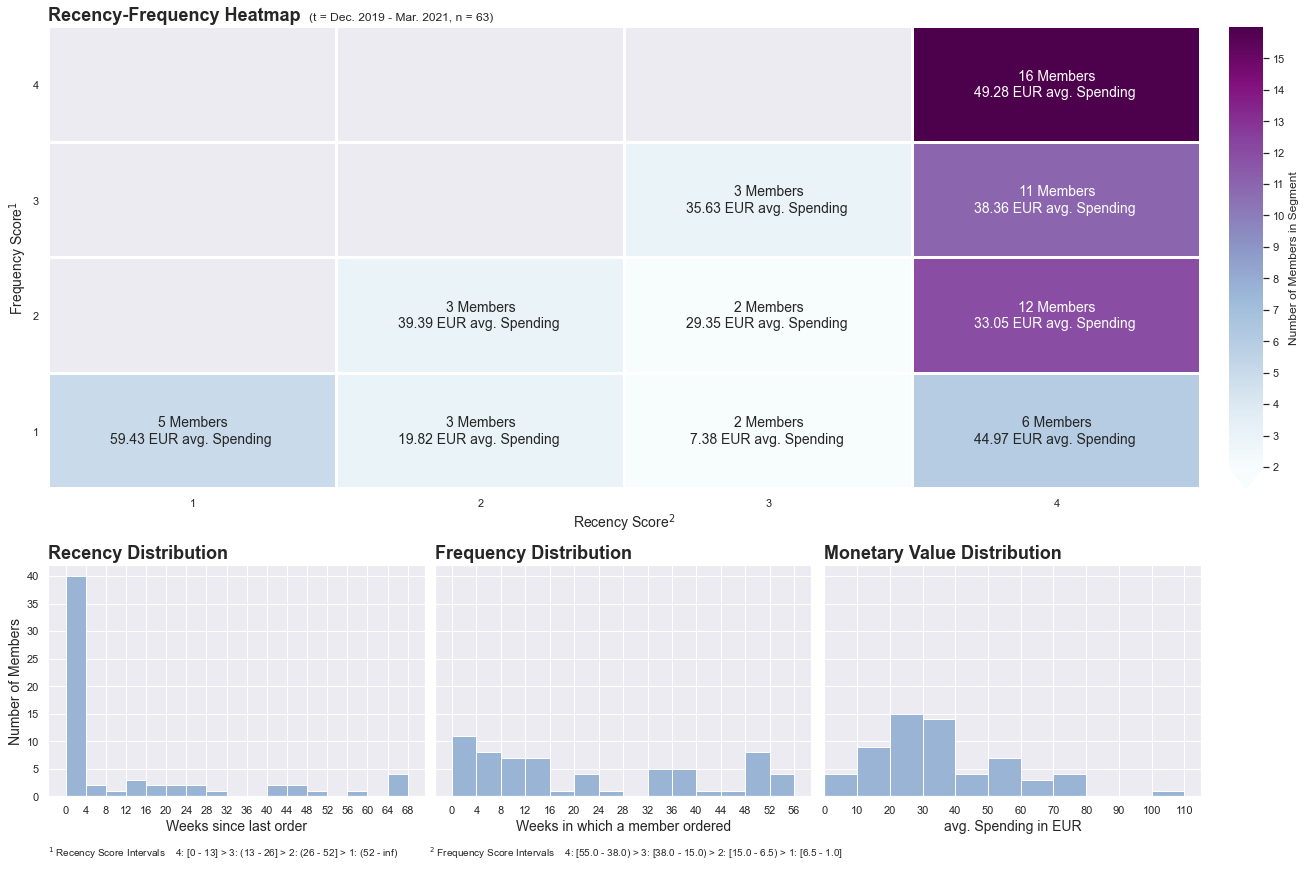

In [109]:
# font and colors
sns.set(rc={"axes.facecolor": "#ebebf1"}) # set grid color
cmap = plt.cm.get_cmap('BuPu')
dist_color = cmap(0.4)
fontsizes = {'t1': 24, 't2': 18, 'labels': 14, 'annot': 14, 'foot': 10}

# Figure and Gridspec
fig = plt.figure(figsize=(18, 12), constrained_layout=True) # choose either constrained_layout or tight_layout
fig.set_constrained_layout_pads(w_pad = 2/72, h_pad = 4/72,
                                wspace = 1/72, hspace = 1/72)
gs_widths = [1, 1, 1]
gs_heights = [1, 1, 1, 0.04]
gs = fig.add_gridspec(4, 3, width_ratios=gs_widths, height_ratios=gs_heights)

# Axes
ax1 = fig.add_subplot(gs[0:2, :])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1], sharey=ax2)
ax4 = fig.add_subplot(gs[2, 2], sharey=ax2)
# Ax5 for footnotes only without grid
with sns.axes_style("white"):
    ax5 = fig.add_subplot(gs[-1, :])
    ax5.axis('off')

# Heatmap (Ax1)
# dont use tight_layout since it pushes the cbar inside the axes. constrained_layout works fine.
cbar_kws = {'label': 'Number of Members in Segment', 'fraction': 0.046, # width of cbar
            "shrink": 1, 'extend': 'min', 'extendfrac': 0.05, 
            "ticks": np.arange(0,16), "drawedges": False}
sns.heatmap(heatmap_count, ax=ax1, cmap=cmap, linewidths=2, 
            annot=heatmap_labels, fmt='s', annot_kws={'fontsize': fontsizes['annot']},
            cbar_kws=cbar_kws)
ax1.set_title('Recency-Frequency Heatmap', fontsize=fontsizes['t2'], fontweight='bold', loc='left')
ax1.annotate(f"(t = {t_min.strftime('%b. %Y')} - {t_max.strftime('%b. %Y')}, n = {n})", xy=(0.226, 1.0126), xycoords='axes fraction')
ax1.set_xlabel('Recency Score$^2$', fontsize=fontsizes['labels']) # superscript wrapped arround $$
ax1.set_ylabel('Frequency Score$^1$', fontsize=fontsizes['labels'])
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0) # rotate yticklabels

# Histogram plots (Ax2-Ax4)

# histogram bin ranges
bins_recency = range(0, int(max(rfm_for_analysis['recency'])+4), 4)
bins_frequency = range(0, int(max(rfm_for_analysis['frequency'])+4), 4)
bins_monetary = range(0, int(max(rfm_for_analysis['monetary_value']))+5, 10)

# recency 
rfm_for_analysis.recency.plot.hist(bins=bins_recency, ax=ax2,
                                   color=dist_color)
ax2.set_title('Recency Distribution', fontsize=fontsizes['t2'], fontweight='bold', loc='left')
ax2.set_xlabel('Weeks since last order', fontsize=fontsizes['labels'])
ax2.set_ylabel('Number of Members', fontsize=fontsizes['labels'])
ax2.set_xticks(bins_recency)

# frequency
rfm_for_analysis.frequency.plot.hist(bins=bins_frequency,
                             ax=ax3,
                             color=dist_color)
ax3.set_title('Frequency Distribution', fontsize=fontsizes['t2'], fontweight='bold', loc='left')
ax3.set_xlabel('Weeks in which a member ordered', fontsize=fontsizes['labels'])
ax3.set_ylabel('Number of Members', fontsize=fontsizes['labels'])
ax3.set_xticks(bins_frequency)

# monetary value
rfm_for_analysis.monetary_value.plot.hist(bins=bins_monetary,
                                   ax=ax4,
                                   color=dist_color)
ax4.set_title('Monetary Value Distribution', fontsize=fontsizes['t2'], fontweight='bold', loc='left')
ax4.set_xlabel('avg. Spending in EUR', fontsize=fontsizes['labels'])
ax4.set_ylabel('Number of Members', fontsize=fontsizes['labels'])
ax4.set_xticks(bins_monetary)
ax4.set_xlim(0, 115) # only a quick fix for not showing outliers: TODO remove outliers in make_dataframe

# Annotations (Ax5)
f_annot = '$^2$ Frequency Score Intervals    4: [{0:.1f} - {1:.1f}) > 3: [{1:.1f} - {2:.1f}) > 2: [{2:.1f} - {3:.1f}) > 1: [{3:.1f} - {4:.1f}]'.format(*np.flip(bin_info['f']))
r_annot = '$^1$ Recency Score Intervals    4: [{0:.0f} - {1:.0f}] > 3: ({1:.0f} - {2:.0f}] > 2: ({2:.0f} - {3:.0f}] > 1: ({3:.0f} - {4:.0f})'.format(*bin_info['r'])

ax5.annotate(f_annot, xy=(0.33, 1), fontsize=fontsizes['foot'],
             xycoords='axes fraction', textcoords='offset points', 
             va='center', ha='left', annotation_clip=False)
ax5.annotate(r_annot, xy=(0., 1), fontsize=fontsizes['foot'],
             xycoords='axes fraction', textcoords='offset points', 
             va='center', ha='left', annotation_clip=False)


## 4.3. KMeans Clustering



In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import SilhouetteVisualizer

### Step 3: Data Normalizing. 

The range of variables shows large variation. K-Means is distance based, so adjusting range common range is required to avoid building biased model.

In [ ]:
rfm_table.head()

,recency,frequency,monetary_value,freq_avg,order_count,lifespan,T,idle_time
member_ID,,,,,,,,
1,0.0,37.0,88.508649,0.755102,106,48.0,48.0,69 days
2,2.0,33.0,24.096364,0.702128,84,46.0,48.0,69 days
3,0.0,34.0,62.907059,0.693878,87,48.0,48.0,69 days
4,48.0,1.0,15.360000,1.000000,2,0.0,48.0,0 days
6,0.0,33.0,67.516970,0.891892,96,36.0,36.0,28 days


In [ ]:
# Data Normalizing

# create  instance of scaler
scaler = MinMaxScaler()

# selecting data to scale from rfm_table
df_to_scale = rfm_table.iloc[:, :3]

# scaling selected data
rfm_normalized = pd.DataFrame(scaler.fit_transform(df_to_scale))

# setting clumn and index (member_IDs) after scaling
rfm_normalized.columns = ['recency', 'frequency', 'monetary_value_avg']
rfm_normalized.index = rfm_table.index 

rfm_normalized.describe()

,recency,frequency,monetary_value_avg
count,45.000000,45.000000,45.000000
mean,0.162500,0.484685,0.379003
std,0.304817,0.363812,0.254603
min,0.000000,0.000000,0.000000
25%,0.000000,0.081081,0.185598
50%,0.000000,0.567568,0.276531
75%,0.125000,0.864865,0.505706
max,1.000000,1.000000,1.000000


### Step 4: Finding optimal numbers of RFM Clusters

[Text(0, 0.5, 'Sum of Squared Error (SSE)'), Text(0.5, 0, 'k clusters')]

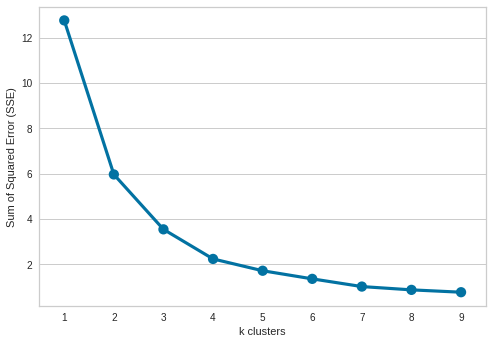

In [ ]:
# Segmenting with K-Means. Identify the optimal k.
SSE = {}

for k in range(1, 10):
    model = KMeans(n_clusters=k, max_iter=1000, random_state=1234).fit(rfm_normalized)
    SSE[k] = model.inertia_ 

ax = sns.pointplot(x=list(SSE.keys()), y=list(SSE.values()))
ax.set(xlabel='k clusters', ylabel='Sum of Squared Error (SSE)')

Text(0, 0.5, 'cluster label')

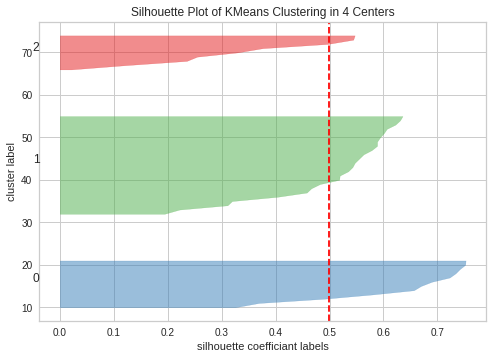

In [ ]:
# silhouette plot
# https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

silhouette = SilhouetteVisualizer(KMeans(3, random_state=1234), colors='yellowbrick')
silhouette.fit(rfm_normalized)

plt.title('Silhouette Plot of KMeans Clustering in 4 Centers')
plt.xlabel('silhouette coefficiant labels')
plt.ylabel('cluster label')

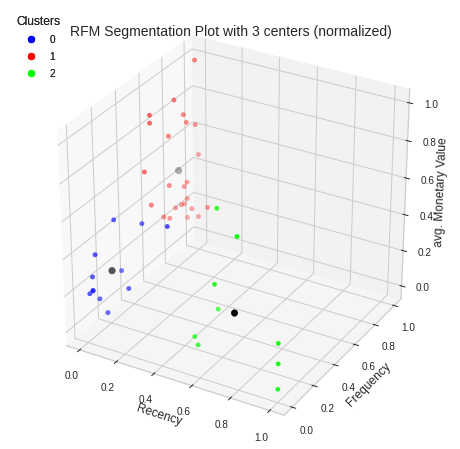

In [ ]:
# 3d scatter plot
n_cluster = 3

model = KMeans(n_cluster, random_state=1234).fit(rfm_normalized)
centers = model.cluster_centers_

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 3d plot
scatter = ax.scatter(rfm_normalized.recency, rfm_normalized.frequency, rfm_normalized.monetary_value_avg, 
           cmap='brg', s=20,
           c=model.predict(rfm_normalized),
           #label=model.predict(rfm_normalized)
           )
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=45, c='black')
ax.set_xlabel('Recency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_zlabel('avg. Monetary Value', fontsize=12)
ax.set_title(f'RFM Segmentation Plot with {n_cluster} centers (normalized)', fontsize=14)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc='upper left', 
                    title="Clusters")
ax.add_artist(legend1)


### Step 5: Identify the clusters for further analysis.

In [ ]:
# Step 5: Identify the clusters for further analysis.
rfm_ = pd.DataFrame(scaler.inverse_transform(rfm_normalized)) # revers normalization
rfm_.columns = rfm_normalized.columns
rfm_['member_ID'] = rfm_table.index
rfm_['cluster_ID'] = model.labels_

In [ ]:
# reformat dataframe before plotting
melted_rfm_normalized = pd.melt(rfm_.reset_index(),
                                id_vars=['member_ID', 'cluster_ID'],
                                value_vars=['recency', 'frequency', 'monetary_value_avg'],
                                var_name='Feature',
                                value_name='Value')

melted_rfm_normalized.head(10)

,member_ID,cluster_ID,Feature,Value
0,1,1,recency,0.0
1,2,1,recency,2.0
2,3,1,recency,0.0
3,4,2,recency,48.0
4,6,1,recency,0.0
5,7,1,recency,7.0
6,9,1,recency,0.0
7,10,1,recency,0.0
8,11,1,recency,0.0
9,12,1,recency,0.0


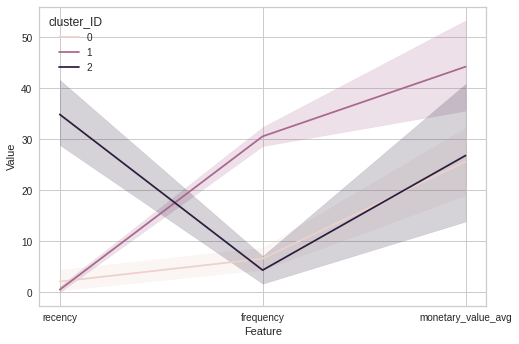

In [ ]:
# plot
sns.lineplot('Feature', 'Value', hue='cluster_ID', 
             data=melted_rfm_normalized)

In [ ]:
# statistics summary for each cluster
rfm_.groupby('cluster_ID').agg({'recency': ['mean', 'min', 'max'],
                                'frequency': ['mean', 'min', 'max'],
                                'monetary_value_avg': ['mean', 'min', 'max', 'count']})


recency              ... monetary_value_avg                 
                 mean   min   max  ...                min        max count
cluster_ID                         ...                                    
0            2.083333   0.0  13.0  ...           7.784000  46.553636    12
1            0.500000   0.0   7.0  ...          17.687059  88.508649    24
2           34.888889  24.0  48.0  ...           3.630000  66.640000     9

[3 rows x 10 columns]

### simple interpretation of clusters
* cluster 0 - new members: low recency and frequency, monetary also lower
* cluster 1 - esteblished members: low recency, high frequency and above average monetray value
* cluster 2 - lost members: highest recency, low frequency, low avg. monetary value

### Step 6: Further analysis

In [ ]:
# add custer id to rfm_table
df_to_merge = rfm_.iloc[:,-2:]

# reset index to turn index 'member_ID' to column
rfm_table_analysis = rfm_table.reset_index().merge(df_to_merge, on='member_ID', 
                                     how='inner', validate='one_to_one')

In [ ]:
rfm_table_analysis.groupby('cluster_ID').describe()

member_ID             ...         idle_time                   
               count       mean  ...               75%                max
cluster_ID                       ...                                     
0               12.0  53.916667  ...  17 days 12:00:00  259 days 00:00:00
1               24.0  23.916667  ...  69 days 00:00:00  119 days 00:00:00
2                9.0  33.555556  ...  13 days 00:00:00   69 days 00:00:00

[3 rows x 72 columns]

In [ ]:
# cluster 0
rfm_table_analysis[rfm_table_analysis.cluster_ID == 0].tail(10)

,member_ID,recency,frequency,monetary_value,freq_avg,order_count,lifespan,T,idle_time,cluster_ID
35,52,13.0,11.0,46.553636,1.000000,32,10.0,23.0,7 days,0
36,54,4.0,14.0,39.789286,1.000000,32,13.0,17.0,7 days,0
37,55,0.0,12.0,18.025833,0.857143,25,13.0,13.0,14 days,0
38,56,6.0,7.0,18.902857,0.875000,13,7.0,13.0,14 days,0
39,57,0.0,5.0,13.208000,0.625000,10,7.0,7.0,28 days,0
40,58,0.0,3.0,19.383333,1.000000,9,2.0,2.0,6 days,0
41,60,0.0,4.0,35.012500,0.800000,9,4.0,4.0,14 days,0
42,61,0.0,2.0,19.295000,0.666667,4,2.0,2.0,12 days,0
43,62,0.0,3.0,19.640000,1.000000,5,2.0,2.0,7 days,0
44,63,0.0,3.0,25.953333,1.000000,8,2.0,2.0,5 days,0


In [ ]:
# cluster 1
rfm_table_analysis[rfm_table_analysis.cluster_ID == 1]

,member_ID,recency,frequency,monetary_value,freq_avg,order_count,lifespan,T,idle_time,cluster_ID
0,1,0.0,37.0,88.508649,0.755102,106,48.0,48.0,69 days,1
1,2,2.0,33.0,24.096364,0.702128,84,46.0,48.0,69 days,1
2,3,0.0,34.0,62.907059,0.693878,87,48.0,48.0,69 days,1
4,6,0.0,33.0,67.516970,0.891892,96,36.0,36.0,28 days,1
5,7,7.0,32.0,28.405625,0.761905,78,41.0,48.0,69 days,1
6,9,0.0,30.0,77.326667,0.612245,77,48.0,48.0,69 days,1
7,10,0.0,26.0,27.101538,0.666667,59,38.0,38.0,28 days,1
8,11,0.0,22.0,37.272727,0.594595,57,36.0,36.0,76 days,1
9,12,0.0,22.0,75.055000,0.448980,53,48.0,48.0,119 days,1
10,13,0.0,34.0,17.687059,0.871795,82,38.0,38.0,28 days,1


In [ ]:
# cluster 2
rfm_table_analysis[rfm_table_analysis.cluster_ID == 2]

,member_ID,recency,frequency,monetary_value,freq_avg,order_count,lifespan,T,idle_time,cluster_ID
3,4,48.0,1.0,15.360000,1.000000,2,0.0,48.0,0 days,2
14,21,48.0,1.0,3.630000,1.000000,1,0.0,48.0,0 days,2
16,23,26.0,4.0,7.432500,0.307692,7,12.0,38.0,62 days,2
21,36,38.0,1.0,66.640000,1.000000,1,0.0,38.0,0 days,2
24,40,48.0,1.0,24.680000,1.000000,2,0.0,48.0,0 days,2
26,42,25.0,12.0,13.506667,1.000000,23,11.0,36.0,8 days,2
27,43,26.0,3.0,12.650000,0.230769,6,12.0,38.0,69 days,2
29,45,24.0,13.0,58.116923,1.000000,36,12.0,36.0,8 days,2
31,48,31.0,3.0,39.373333,0.600000,10,4.0,35.0,13 days,2


### RFM Scoring + K-Means

timedelta test

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# bins
freq = 'W'
r_range = [0, 0.25, 0.5, 1, np.inf]
freqs = {'W': 52, 'M': 12, 'Q': 4}
r_range = [x * freqs[freq] for x in r_range]
r_range

[0, 13.0, 26.0, 52, inf]

In [ ]:
period_end = pd.Timestamp('2020-12-12')
recency = pd.Timestamp('2020-10-09')

print('in Weeks', (period_end - recency) // np.timedelta64(1, 'W'))
print('in Months', (period_end - recency) // np.timedelta64(1, 'M'))
print('in Quarters', (period_end - recency) // np.timedelta64(3, 'M'))

in Weeks 9
in Months 2
in Quarters 0


In [ ]:
freqs_timedelta = {'W': np.timedelta64(1, 'W'), 'M': np.timedelta64(1, 'M'), 'Q': np.timedelta64(3, 'M')}